In [ ]:
!pip install keras-unet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the modified keras_unet
!ls "/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Code/keras-unet/"

%cd "/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Code/keras-unet/"

!python setup.py install 

CHANGELOG.md  keras_unet	   notebooks	     setup.py
docs	      keras_unet.egg-info  README.md	     tests
input	      LICENSE		   requirements.txt
/content/drive/.shortcut-targets-by-id/1k2fyapEMr2C8S-A4cmxr0DRCgmBtJk5G/Tillämpad Bioinformatik (slutkursen)/Code/keras-unet
running install
running bdist_egg
running egg_info
writing keras_unet.egg-info/PKG-INFO
writing dependency_links to keras_unet.egg-info/dependency_links.txt
writing top-level names to keras_unet.egg-info/top_level.txt
reading manifest file 'keras_unet.egg-info/SOURCES.txt'
writing manifest file 'keras_unet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/keras_unet
copying keras_unet/metrics.py -> build/lib/keras_unet
copying keras_unet/__init__.py -> build/lib/keras_unet
copying keras_unet/utils.py -> build/lib/keras_unet
copying keras_unet/metrics_np.py -> build/lib/keras_unet
copying keras_unet/loss

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import sys
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras_unet.utils import plot_imgs
from sklearn.model_selection import train_test_split
from keras_unet.models import custom_unet
from keras.callbacks import ModelCheckpoint
from keras_unet.metrics import iou, iou_thresholded
from keras.optimizers import Adam, SGD
from keras_unet.utils import get_augmented
from keras_unet.utils import plot_segm_history
from sklearn.preprocessing import label_binarize
import time
from sklearn.metrics import roc_curve, auc, roc_auc_score
import csv

%cd "/content/"

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
train_images = sorted(glob.glob("/content/drive/My Drive/UNet/TrainingImages/*.tif"))
train_masks = sorted(glob.glob("/content/drive/My Drive/UNet/TrainingLabels/*.tif"))

test_images = sorted(glob.glob("/content/drive/My Drive/UNet/IndependentTestImages/*.tif"))
test_masks = sorted(glob.glob("/content/drive/My Drive/UNet/IndependentTestLabels/*.tif"))

In [ ]:
def prepare_images_masks(images, masks):
    
    I_list = []
    M_list = []
    for image, mask in zip(images, masks):
        I = Image.open(image)
        M = Image.open(mask)

        I = np.array(I)
        M = np.array(M)

        I_list.append(I/(I.max()))
        M_list.append(M/(M.max()))

    X = np.asarray(I_list, dtype=np.float32)
    Y = np.asarray(M_list, dtype=np.float32)

    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) 
    Y = Y.reshape(Y.shape[0], Y.shape[1], Y.shape[2], 1)
    
    return X, Y


X, Y = prepare_images_masks(train_images, train_masks)
X_test, Y_test = prepare_images_masks(test_images, test_masks)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.75, random_state=33)

print("# X_train: %d" % X_train.shape[0])
print("# Y_train: %d" % Y_train.shape[0])
print("# X_val: %d" % X_val.shape[0])
print("# Y_val: %d" % Y_val.shape[0])

# X_train: 6
# Y_train: 6
# X_val: 2
# Y_val: 2


In [ ]:
train_gen = get_augmented(
    X_train, Y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=360.0,
        fill_mode='constant')
)

In [ ]:
# Parameters

# Currently set to train 4 networks
layers = [4]
filters = [12]
kernel_sizes = [3,5,7,9]


In [ ]:
input_shape = X_train[0].shape

# Initialize arrays for saving data: shape, time elapsed, auc, fpr, tpr
shapes = []
time_elapsed = []
auc_list = []
fpr_list = []
tpr_list = []

# Parse through each combination of parameters
for layer in layers:
  for filter in filters:
    for kernel in kernel_sizes:
      

      # Define net architecture
      model = custom_unet(
        input_shape,
        filters=filter,
        kernel_size=(kernel, kernel), 
        num_layers=layer
      )

      # Define file name
      model_filename = f'UNet_L{layer}_F{filter}_S{kernel}x{kernel}_Adam.h5'
      
      # Comment or remove this section to train without early stopping
      my_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10),
        tf.keras.callbacks.ModelCheckpoint(filepath='model.' + model_filename,
                                          verbose=1, 
                                          monitor='val_loss', 
                                          save_best_only=True)
      ]
      #

      model.compile(
        optimizer=Adam(), 
        #optimizer=SGD(lr=0.0001, momentum=0.9),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.BinaryAccuracy()]
      )

      # Measure the time
      start_time = time.time()
      
      history = model.fit_generator(
        train_gen,
        steps_per_epoch=10,
        epochs=200,
        validation_data=(X_val, Y_val),
        callbacks=[my_callbacks]
      )

      end_time = time.time()
      elapsed_time = (end_time - start_time)/60

      # Saved your trained model to Google Drive 
      model.save(F"/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/{model_filename}")

      # Preditions
      Y_pred = model.predict(X_test)

      N_Y_pred = Y_pred.shape[0]
      Y_score = np.empty(())
      Y_true = np.array(())

      for i in range(N_Y_pred):
          I_score = Y_pred[i, :, :, :]
          I_score = I_score.flatten()
          
          I_true = Y_test[i, :, :, :]
          I_true = I_true.flatten()
          I_true_b = label_binarize(I_true, classes=[0, 1])
          
          if i == 0:
              Y_score = I_score
              Y_true = I_true_b
          else:
              Y_score = np.concatenate((Y_score, I_score), axis = 0)
              Y_true = np.concatenate((Y_true, I_true_b), axis = 0)
          
      # Calculate false and true positive rate as well as the AUC       
      fpr, tpr, _ = roc_curve(y_true=Y_true, y_score=Y_score)
      roc_auc = auc(fpr, tpr)

      # Add values to the arrays
      shapes.append(f'L{layer}_F{filter}_S{kernel}x{kernel}')
      time_elapsed.append(elapsed_time)
      auc_list.append(roc_auc)
      fpr_list.append(fpr)
      tpr_list.append(tpr)

# Save runtimes for later plotting
with open("/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/runtimes_adam.csv", 'w', newline='') as myfile:
  wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
  for i in range(len(layers)*len(filters)*len(kernel_sizes)):
    wr.writerow([shapes[i], time_elapsed[i]])


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 0.6944 - binary_accuracy: 0.6433
Epoch 00001: val_loss improved from inf to 2.40386, saving model to model.UNet_L4_F12_S3x3_Adam.h5
10/10 [==============================] - 1s 138ms/step - loss: 0.6944 - binary_accuracy: 0.6433 - val_loss: 2.4039 - val_binary_accuracy: 0.2695
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.5653 - binary_accuracy: 0.7995
Epoch 00002: val_loss did not improve from 2.40386
10/10 [==============================] - 1s 62ms/step - loss: 0.5653 - binary_accuracy: 0.7995 - val_loss: 29.6810 - val_binary_accuracy: 0.2695
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 0.4877 - binary_accuracy: 0.8670
Epoch 00003: val_loss did not improve from 2.40386
10/10 [==============================] - 1s 62ms/step - loss: 0.4877 - binary_accuracy: 0.8670 - val_loss: 10.5188 - val_binary

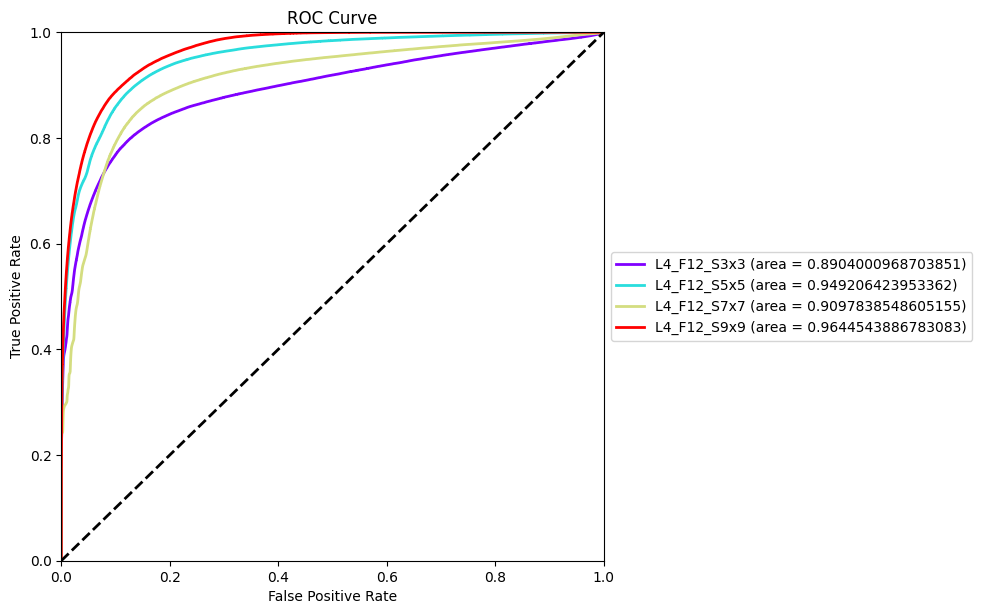

In [ ]:
# Plot ROC curves from the saved models
from matplotlib.pyplot import cm
from cycler import cycler

# For larger plot
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.figure()
lw = 2

# Initialize color cycle
n_lines = len(layers)*len(filters)*len(kernel_sizes)
colors=cm.rainbow(np.linspace(0,1,n_lines))

plt.rc('axes', prop_cycle=(cycler('color', colors)))

for layer in layers:
  for filter in filters:
    for kernel in kernel_sizes:

      # Read in model-file
      model_filename = f"UNet_L{layer}_F{filter}_S{kernel}x{kernel}_Adam.h5"
      model = load_model(f"/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/{model_filename}")


      # Predition
      Y_pred = model.predict(X_test)

      N_Y_pred = Y_pred.shape[0]
      Y_score = np.empty(())
      Y_true = np.array(())

      for i in range(N_Y_pred):
          I_score = Y_pred[i, :, :, :]
          I_score = I_score.flatten()
          
          I_true = Y_test[i, :, :, :]
          I_true = I_true.flatten()
          I_true_b = label_binarize(I_true, classes=[0, 1])
          
          if i == 0:
              Y_score = I_score
              Y_true = I_true_b
          else:
              Y_score = np.concatenate((Y_score, I_score), axis = 0)
              Y_true = np.concatenate((Y_true, I_true_b), axis = 0)
          
      # Calculate false and true positive rate as well as the AUC       
      fpr, tpr, _ = roc_curve(y_true=Y_true, y_score=Y_score)
      roc_auc = auc(fpr, tpr)

      plt.plot(fpr, tpr, lw=lw, label=f'L{layer}_F{filter}_S{kernel}x{kernel} (area = {roc_auc})')

# Plot
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



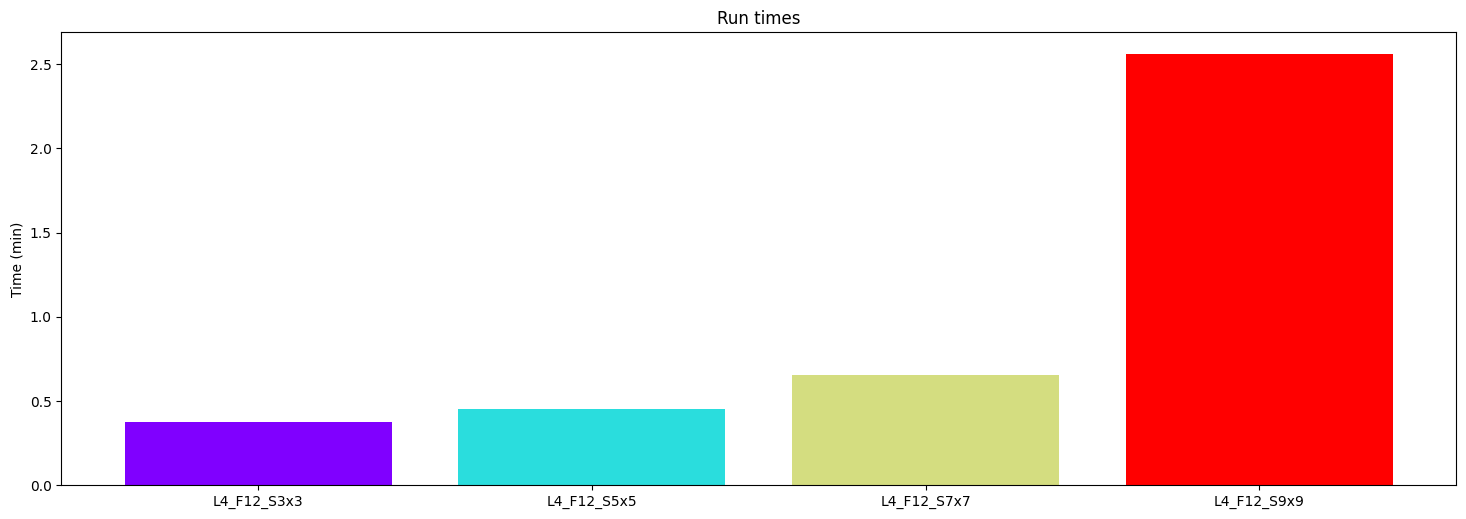

In [ ]:
# Print the training times
with open("/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/runtimes_adam.csv", mode='r') as infile:
    reader = csv.reader(infile)
    D = {rows[0]:float(rows[1]) for rows in reader}


# For larger plot
plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.figure()

# Initialize color set
n_lines = len(layers)*len(filters)*len(kernel_sizes)
colors=cm.rainbow(np.linspace(0,1,n_lines))

# Plot the barplot
plt.bar(list(D.keys()), list(D.values()), color=colors)
plt.title('Training times')
plt.ylabel('Time (min)')
plt.show()
